In [1]:
%matplotlib inline

import sys
sys.path.insert(0, "../")
sys.path.insert(0, "../dataset_generator/")

import torch
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import scipy.stats
plt.style.use("project_style.mplstyle")
from tqdm import tqdm

import stats
import environments
import analysis_tools

In [2]:
def error_kde(errors, n, ylim, bw = None):
    kdes = np.zeros((n, errors.shape[-1]))
    eval_errs = np.linspace(0, ylim, n)
    
    for i in range(errors.shape[-1]):
        kernel = scipy.stats.gaussian_kde(errors[:,i], bw_method = bw)
        kdes[:, i] = kernel(eval_errs) 
    return kdes

def inset_walls(ax, walls, scale = 0.2):
    w = np.amax(np.abs(walls))*1.1*scale
    h = w
    subax = ax.inset_axes(bounds = [0.65, 0.65, w, h])
    for wall in walls:
        subax.plot(*walls.T, "w", linewidth = 0.25)
        subax.axis("equal")
        subax.axis("off")

In [3]:
name = "al1_10_l2_0"
path = f"../models/{name}"
model, params = analysis_tools.load_model(path, device = "cpu", model_type = "RNN") # model of interest

timesteps = 500 # timesteps per sequence
samples = 100 # of samples for each environment

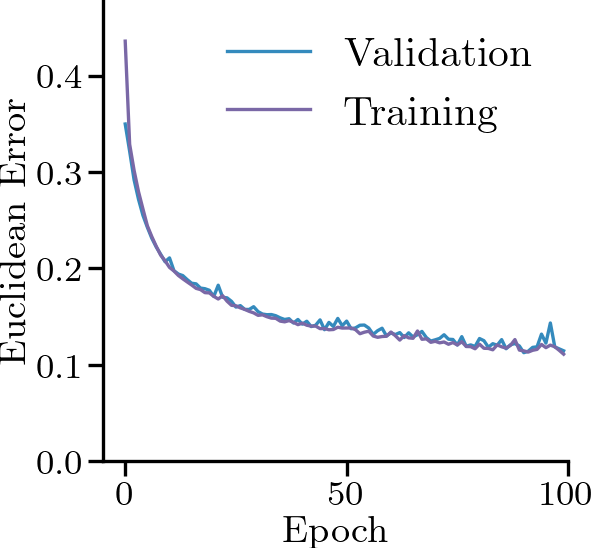

In [31]:
training_losses = np.load(f"{path}/RNN_metrics.npz")
val_euclid = training_losses["val_euclid"]
train_euclid = training_losses["train_euclid"]
plt.figure(figsize = (2,2))
plt.plot(val_euclid, label = "Validation")
plt.plot(train_euclid, label = "Training") # first train step is misleading
plt.axis([-5, len(val_euclid), 0.0,  np.amax(train_euclid)*1.1])
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Euclidean Error")
# plt.savefig(f"./figures/{name}_RNN_training_history")

In [4]:
envs = environments.Environments()
walls = envs.envs
envs = list(envs.envs) # :)

loss = np.zeros((len(envs), samples, timesteps))

In [5]:
for i, env in enumerate(tqdm(envs)):
    sequence = samples*[env] # sample environment several times
    x, r, v, c = analysis_tools.test_dataset(sequence, timesteps = timesteps, context = params["context"], trajectories = True)
    dataset = [((x[0][i,None], x[1][i,None]), x[1][i,None]) for i in range(len(sequence))] # repackage
    _, _, _, preds = model.inference(dataset)
    loss[i] = np.linalg.norm(preds - r, axis = -1)

100%|██████████| 6/6 [01:46<00:00, 17.75s/it]


Text(0.5, 0.01, 'Trajectory Step')

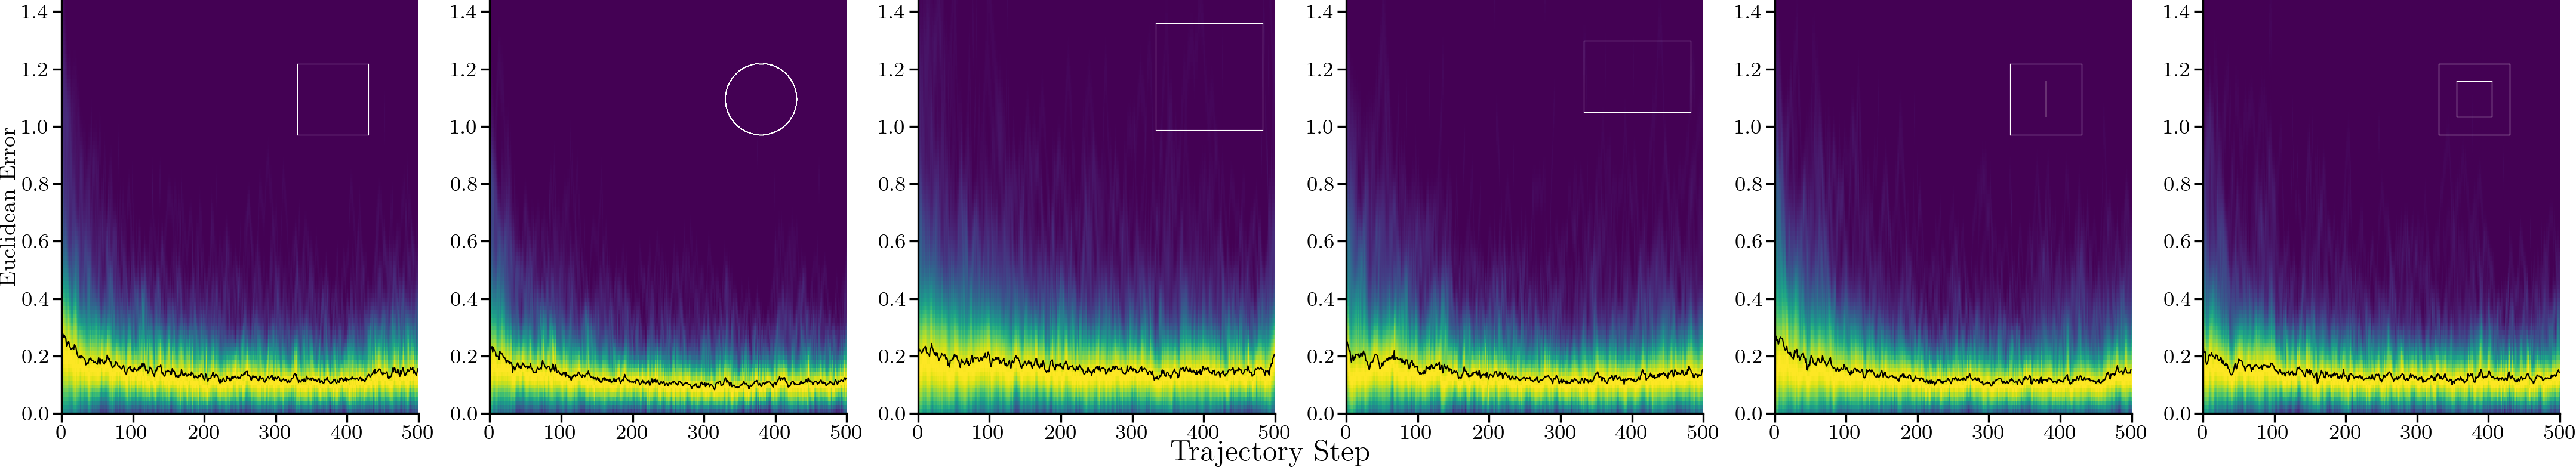

In [74]:
fig, ax = plt.subplots(1, len(envs), figsize = (18, 3))

ylim = np.amax(loss)*0.75

for i, current_loss in enumerate(loss):    
    kde = error_kde(current_loss, 100, ylim)
    kde = kde / np.amax(kde, axis = 0)[None]
    ax[i].imshow(kde, origin = "lower", aspect= "auto", extent = [0, timesteps, 0, ylim])#, vmin = 0, vmax = np.amax(kde))
    ax[i].plot(np.median(current_loss, axis = 0), "-k", linewidth = 0.5)
    inset_walls(ax[i], walls[envs[i]])
    #ax[i].axis("off")
ax[0].set_ylabel("Euclidean Error")
fig.supxlabel("Trajectory Step")


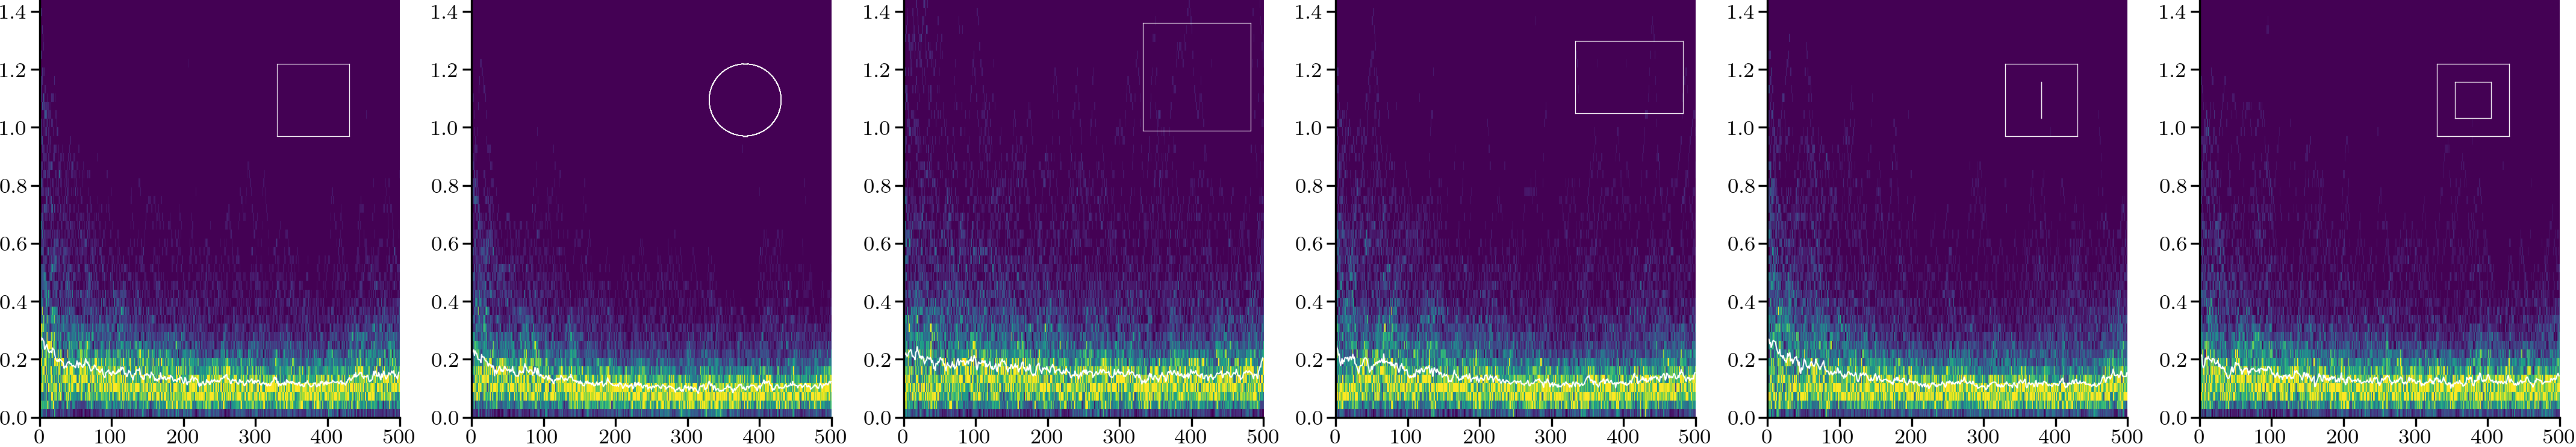

In [18]:
ny = 50
hist = np.zeros((len(envs), ny, timesteps))

fig, ax = plt.subplots(1, len(envs), figsize = (18, 3))

ybins = np.linspace(0, ylim, ny)
xbins = np.linspace(0, timesteps-1, timesteps)
timestamps = np.array([xbins for i in range(samples)])

for i, current_loss in enumerate(loss):
    hist = np.histogram2d( timestamps.ravel(), current_loss.ravel(),bins = [xbins, ybins])[0]
    hist /= np.amax(hist, axis = 1, keepdims = True)
    ax[i].imshow(hist.T, origin = "lower", aspect= "auto", extent = [0, timesteps, 0, ylim])#, vmin = 0)#, vmax = np.amax(kde))
    ax[i].plot(np.median(current_loss, axis = 0), "-w", linewidth = 0.5)
    inset_walls(ax[i], walls[envs[i]])

In [40]:
# Show trajectories for square environments
x, r, v, c = analysis_tools.test_dataset(['square']*2, timesteps = 500, context = params["context"], trajectories = True)
dataset = [((x[0][i,None], x[1][i,None]), x[1][i,None]) for i in range(len(x))] # repackage
_, _, _, preds = model.inference(dataset)

torch.Size([2, 500, 8]) torch.Size([2, 500, 2])


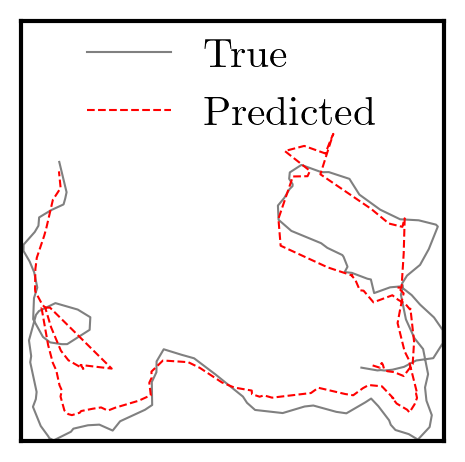

In [75]:
a = 0
b = 250
c = 380

plt.figure(figsize=(2, 2))
plt.plot(r[a,b:c,0], r[a,b:c,1], "gray", label = "True", linewidth = 0.5)
plt.plot(preds[a,b:c,0], preds[a,b:c,1], "--r", label = "Predicted", linewidth = 0.5)
for wall in walls["square"]:
    plt.plot(wall[:,0], wall[:,1], "k", linewidth = 1)
plt.axis("off")
plt.legend()


# plt.savefig("./figures/pred_trajectory")